In [19]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

## Tutorial 12
### Problem 1 :  Gibbs Sampling for MIMO Channel
We consider a point-to-point MIMO system with $N_t$ transmit and $N_r$ receive antennas over a frequency
flat fading channel $H$. The
corresponding channel model is

$$\underline{Y} = H\underline{X} + \underline{N}$$
where $\underline{X} \sim \mathcal{N}(\underline{0},\sigma_{x}^2I)$ and $\underline{N} \sim \mathcal{N}(\underline{0},\sigma_{n}^2I)$. The entries of $H$ are
assumed iid zero-mean and unit-variance Gaussian.


**a)** Implement the system model so that you can obtain received samples $\vec{y}$.

In [20]:
# Parameters
Nt = 4 # number of transmit antennas
Nr = 2 # number of receive antennas
sigma2x = 2 # variance of transmit signal
sigma2n = 3 # variance of noise

In [21]:
# System model
H = np.random.randn(Nr,Nt)
x = np.random.randn(Nt,1) * np.sqrt(sigma2x)
n = np.random.randn(Nr,1) * np.sqrt(sigma2n)
y = H.dot(x) + n

**b)** Implement the closed form expression for the mean-square error estimate.

In [22]:
# Closed form solution
Cx = sigma2x * np.eye(Nt)
Cn = sigma2n * np.eye(Nr)
Cy = H.dot(Cx).dot(H.T) + Cn
xhat = Cx.dot(H.T).dot(np.linalg.inv(Cy).dot(y))
print(f'Closed form solution:\n {xhat}')

Closed form solution:
 [[ 0.09848339]
 [-0.6742976 ]
 [-0.3298677 ]
 [-0.31225202]]


**d)** Implement a Gibbs sampler using the previously derived expressions.

In [23]:
def gibbs_sampling(sample_fun, y, x0, num_samples):
    """
    Implements the Gibbs sampling procedure.
    The parameter sample_fun is a function handle that
    implements the sampling from the individual conditional
    component distributions. Its signature is:

    def sample_fun(k, x0): pass

    where k defines the component and x0 is the vector that specifies
    in which the other components should be evaluated.
    
    Returns a matrix x of size Nt x num_samples that contains the samples
    returned by the sample_fun()
    """

    Nt = x0.shape[0]
    x = np.empty((Nt,num_samples), dtype=float)

    s  = 0

    while s < num_samples:
        for k in np.arange(Nt):
            x[k,s] = sample_fun(k, x0)
            x0[k] = x[k,s]
        s = s + 1
    
    return x

def sampling_funs(y, H, k, x0):
    """
    Implements the actual sampling for the conditional mean case. The intermediate steps
    and quantities (means, covariance matrices, etc.) have been derived and explained
    in the lecture notes.    
    """

    Nr = H.shape[0]
    Nt = H.shape[1]
    Cxiz = np.hstack([sigma2x * H[:,k].reshape((1,Nr)), np.zeros((1,Nt-1))])
    Cy = H.dot(Cx).dot(H.T) + sigma2n * np.eye(Nr)
    idx = np.arange(Nt)
    idx = np.delete(idx, k)
    z = np.vstack([y, x0[idx]])
    Cz = np.vstack([np.hstack([Cy, sigma2x * H[:,idx]]), np.hstack([sigma2x * H[:,idx].T, sigma2x * np.eye(Nt-1)])])
    mu = Cxiz.dot(np.linalg.inv(Cz).dot(z))
    sigma2 = sigma2x - Cxiz.dot(np.linalg.inv(Cz)).dot(Cxiz.T)

    return np.random.randn(1,1) * np.sqrt(sigma2) + mu

In [26]:
# calculate xhat thorugh Gibbs sampling
x0 = np.random.randn(Nt,1)
num_samples = 5000
x = gibbs_sampling(lambda k, x0: sampling_funs(y, H, k, x0), y, x0, num_samples)

In [27]:
print(f'Closed form solution:\n {xhat}')
print(f'Gibbs sampling approximation:\n {np.mean(x,axis=1).reshape(xhat.shape)}')

Closed form solution:
 [[ 0.09848339]
 [-0.6742976 ]
 [-0.3298677 ]
 [-0.31225202]]
Gibbs sampling approximation:
 [[ 0.12632278]
 [-0.65907842]
 [-0.31706633]
 [-0.30714834]]


**d)** Compare the quality of the Gibbs sampler for different sampling strategies.

In [8]:
num_samples = 10 ** np.array([1, 2, 3, 4])
trials = 10

xhat_tmp = np.zeros((Nt, trials))
mse = np.zeros(len(num_samples))

for i in range(len(num_samples)):
    print('Working on sample size: {}\n'.format(num_samples[i]))
    for j in range(trials):
        print(' {}'.format(j), end =" ")
        x0 = np.random.randn(Nt,1)
        tmp_samples = gibbs_sampling(lambda k, x0: sampling_funs(y, H, k, x0), y, x0, num_samples[i])
        xhat_tmp[:,j] = np.mean(tmp_samples, axis=1)
    print('\n')
    tmp = xhat - xhat_tmp
    mse[i] = np.mean(np.sum(tmp**2,axis=0))

Working on sample size: 10

 0  1  2  3  4  5  6  7  8  9 

Working on sample size: 100

 0  1  2  3  4  5  6  7  8  9 

Working on sample size: 1000

 0  1  2  3  4  5  6  7  8  9 

Working on sample size: 10000

 0  1  2  3  4  5  6  7  8  9 



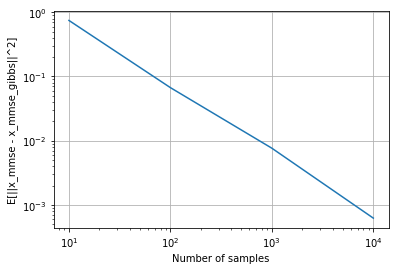

In [9]:
plt.loglog(num_samples, mse)
plt.xlabel('Number of samples')
plt.ylabel('E[||x_mmse - x_mmse_gibbs||^2]')
plt.grid()
plt.show()